# Sentinel 2 high resolution imagery

<b>Table of Contents</b>

- Overview
- Setup
    - Get authentication token
- Data layers
- Querying the data layers
    - Point query
    - Raster query
- References
  
## Overview

Sentinel-2 is a set of two satellites in polar orbit 180 degrees apart. It monitors land surface and coastal waters every 5 days at the equator and more frequently at mid-latitudes. The coverage is between latitudes 56° south and 84° north. Images are in 13 spectral bands at various ground resolutions: 4 bands at 10 m, 6 at 20 m and 3 at 60 m; the orbital swath is 290 km wide. Level 2A (L2A) images are 100x100 km ortho-rectified and spatially registered on a global reference system; they are corrected for the atmosphere so they represent ground conditions. Currently Geospatial APIs ingests Bands 4 (red), 8 (NIR) and SCL (Scene Classification). An NDVI layer, called "NDVI sh", is calculated from Bands 4 and 8. Tiles are ingested on request. Currently there is some coverage for tiles in USA, Brazil, India and the Netherlands for selected days in 2018 and 2019. Timestamps in this dataset are rounded down to 0:00 UTC from the Satellite's sensing time.

## Setup

Before starting, you have to install IBM EI Geospatial python SDK i.e ibmpairs and other modules needed to run this sample, mentioned in the cell below.

<b>Note:</b> To run this notebook seamlessly, you have to first configure your Geospatial APIs' credentials in a file named `secrets.ini` in the below format:

```
[EI]
api.api_key = <Your Geospatial APIs API key>
api.tenant_id = <Your Geospatial APIs Tenant ID>
api.org_id = <Your Geospatial APIs Org ID>
```

Keep the secrets.ini file at an appropriate relative location of this notebook. For example, as specified in the below config.

```config.read('../../../../auth/secrets.ini')```

In [ ]:
%pip install ibmpairs
%pip install configparser
%pip install matplotlib

In [1]:
import ibmpairs.client as client
import ibmpairs.catalog as catalog
import ibmpairs.query as query
import pandas as pd
import configparser
import json
import numpy as np
from PIL import Image as PILImage
from IPython.display import Image, display
import matplotlib.pyplot as plt
import os

Now, let us create a client object using the API_KEY, TENANT_ID (or CLIENT_ID) and ORG_ID to create an authenticated HTTP client Authentication token using 'ibmpairs.client' module, to use it in the subsequent steps.

### Get authentication token

In [2]:
config = configparser.RawConfigParser()
config.read('../../../../auth/secrets.ini')
# Best practice is not to include secrets in source code so we read
# an api key, tenant id and org id from a secrets.ini file.
# You could set the credentials in-line here but we don't
# recommend it for security reasons.

EI_API_KEY    = config.get('EI', 'api.api_key')
EI_TENANT_ID  = config.get('EI', 'api.tenant_id') 
EI_ORG_ID     = config.get('EI', 'api.org_id')  

EI_client_v3  = client.get_client(api_key   = EI_API_KEY,
                                    tenant_id = EI_TENANT_ID,
                                    org_id    = EI_ORG_ID,
                                    legacy    = False,
                                    version   = 3
                                   )

2025-01-20 19:18:07 - paw - INFO - The client authentication method is assumed to be OAuth2.
2025-01-20 19:18:07 - paw - INFO - Legacy Environment is False
2025-01-20 19:18:07 - paw - INFO - The authentication api key type is assumed to be IBM EIS, because the api key prefix 'PHX' is present.
2025-01-20 19:18:16 - paw - INFO - Authentication success.
2025-01-20 19:18:16 - paw - INFO - HOST: https://api.ibm.com/geospatial/run/na/core/v3


## Data layers
We shall start by querying the catalog to retrieve the Data Set ID and the Data Layers that form the dataset.

In [92]:
pd.set_option('display.max_colwidth', None)
search_df=catalog.search("Sentinel 2 high resolution imagery")
search_df[['dataset_id','data_layer_id','data_layer_name','data_layer_description_short','data_layer_level','data_layer_type','data_layer_unit','data_set_name','data_set_description_short']]

,dataset_id,data_layer_id,data_layer_name,data_layer_description_short,data_layer_level,data_layer_type,data_layer_unit,data_set_name,data_set_description_short
0,177,49360,Band 4 (red),"Central wavelength 664.5/665.0 nm, bandwidth 38/39 nm respectively (Sentinel 2 A/B satellite).",23,Raster,,Sentinel 2 high resolution imagery,Images from the European Space Agency (ESA) Sentinel 2 pair of satellites that view land surface regions.
1,177,49361,Band 8 (NIR),"Central wavelength 835.1/833.0 nm, bandwidth 145/133 nm respectively (Sentinel 2 A/B satellite).",23,Raster,,Sentinel 2 high resolution imagery,Images from the European Space Agency (ESA) Sentinel 2 pair of satellites that view land surface regions.
2,177,49362,Scene classification,"Pixel-by-pixel classification in image of 4 types of clouds, cloud shadows, vegetation, soils/deserts, water and snow.",22,Raster,,Sentinel 2 high resolution imagery,Images from the European Space Agency (ESA) Sentinel 2 pair of satellites that view land surface regions.
3,177,49464,Normalized difference vegetation index,A measure of the amount of vegetation at the pixel.,23,Raster,,Sentinel 2 high resolution imagery,Images from the European Space Agency (ESA) Sentinel 2 pair of satellites that view land surface regions.
4,177,49680,Band 2 (blue),"Central wavelength 496.6/492.1 nm, bandwidth 98/98 nm respectively (Sentinel 2 A/B satellite).",23,Raster,,Sentinel 2 high resolution imagery,Images from the European Space Agency (ESA) Sentinel 2 pair of satellites that view land surface regions.
5,177,49681,Band 3 (green),"Central wavelength 560.0/559.0 nm, bandwidth 45/46 nm respectively (Sentinel 2 A/B satellite).",23,Raster,,Sentinel 2 high resolution imagery,Images from the European Space Agency (ESA) Sentinel 2 pair of satellites that view land surface regions.
6,177,49682,Band 5 (vegetation red edge),"Central wavelength 703.9/703.8 nm, bandwidth 19/20 nm respectively (Sentinel 2 A/B satellite).",22,Raster,,Sentinel 2 high resolution imagery,Images from the European Space Agency (ESA) Sentinel 2 pair of satellites that view land surface regions.
7,177,49683,Band 6 (vegetation red edge),"Central wavelength 740.2/739.1 nm, bandwidth 18/18 nm respectively (Sentinel 2 A/B satellite).",22,Raster,,Sentinel 2 high resolution imagery,Images from the European Space Agency (ESA) Sentinel 2 pair of satellites that view land surface regions.
8,177,49684,Band 7 (vegetation red edge),"Central wavelength 782.5/779.7 nm, bandwidth 28/28 nm respectively (Sentinel 2 A/B satellite).",22,Raster,,Sentinel 2 high resolution imagery,Images from the European Space Agency (ESA) Sentinel 2 pair of satellites that view land surface regions.
9,177,49685,Band 8a (narrow IR),"Central wavelength 864.8/864.0 nm, bandwidth 33/32 nm respectively (Sentinel 2 A/B satellite).",22,Raster,,Sentinel 2 high resolution imagery,Images from the European Space Agency (ESA) Sentinel 2 pair of satellites that view land surface regions.


As seen above, the Sentinel 2 high resolution imagery Data Set of ID 177 has seventeen Data Layers. This collection of Data Layers are fundamental for applications like vegetation monitoring, land cover classification, water quality, and environmental monitoring.
Each of the Data Layers are identified by a unique Data Layer ID. To gain a better understanding of the Data Set and its geospatial and temporal coverage as well as other relevant metadata, we can make further queries to the catalog submodule as mentioned in the [tutorials](https://ibm.github.io/ibmpairs/tutorials/quickstart/quickstartcatalog.html).

## Querying the data layers
Given the large number of data layers in this data set, we will focus on selecting specific layers of interest for our queries.

### Point query
Next, we shall perform a point query for two different locations in the USA to observe values for various bands of the dataset.

In [90]:
query_result = query.submit(
    {
        "layers" : [
            {
                "type" : "raster", 
                "id" : "49360"
            },
            {
                "type" : "raster", 
                "id" : "49361"
            },
            {
                "type" : "raster", 
                "id" : "49362"
            },
            {
                "type" : "raster", 
                "id" : "49464"
            },
            {
                "type" : "raster", 
                "id" : "49680"
            },
            {
                "type" : "raster", 
                "id" : "49681"
            },
            {
                "type" : "raster", 
                "id" : "49682"
            },
            {
                "type" : "raster", 
                "id" : "49683"
            },
            {
                "type" : "raster", 
                "id" : "49684"
            },
            {
                "type" : "raster", 
                "id" : "49685"
            },
            {
                "type" : "raster", 
                "id" : "49686"
            },
            {
                "type" : "raster", 
                "id" : "49687"
            },
            {
                "type" : "raster", 
                "id" : "49688"
            },
            {
                "type" : "raster", 
                "id" : "49689"
            },
            {
                "type" : "raster", 
                "id" : "49690"
            },
            {
                "type" : "raster", 
                "id" : "49691"
            }
        ],
        "spatial" : {
            "type" : "point",
            "coordinates" : [
                31.343562, -97.931835,    
                29.236392, -99.635925
            ] 
        },
        "temporal" : {
            "intervals" : [
                {
                    "start" : "2018-01-10T00:00:00Z", 
                    "end" : "2018-01-10T00:00:00Z"
                }
            ]
        }
    } , client=EI_client_v3)

point_df = query_result.point_data_as_dataframe()
point_df['datetime'] = pd.to_datetime(point_df['timestamp'] , unit='ms', errors = 'coerce')
point_df['datetime'] = point_df['datetime'].dt.strftime('%Y-%m-%dT%H:%M:%SZ')
point_df = point_df.drop(columns=['timestamp'])
point_df

2025-01-10 18:17:02 - paw - INFO - TASK: submit STARTING.
2025-01-10 18:17:09 - paw - INFO - TASK: submit COMPLETED.


,layer_id,layer_name,dataset,longitude,latitude,value,datetime
0,49360,Band 4 (red),Sentinel 2 high resolution imagery,-99.635925,29.236392,0.6224000000000001,2018-01-10T00:00:00Z
1,49360,Band 4 (red),Sentinel 2 high resolution imagery,-97.931835,31.343562,0.7814,2018-01-10T00:00:00Z
2,49361,Band 8 (NIR),Sentinel 2 high resolution imagery,-99.635925,29.236392,0.6383,2018-01-10T00:00:00Z
3,49361,Band 8 (NIR),Sentinel 2 high resolution imagery,-97.931835,31.343562,0.7514000000000001,2018-01-10T00:00:00Z
4,49362,Scene classification,Sentinel 2 high resolution imagery,-99.635925,29.236392,9.0,2018-01-10T00:00:00Z
5,49362,Scene classification,Sentinel 2 high resolution imagery,-97.931835,31.343562,9.0,2018-01-10T00:00:00Z
6,49464,Normalized difference vegetation index,Sentinel 2 high resolution imagery,-99.635925,29.236392,0.012599999999999945,2018-01-10T00:00:00Z
7,49464,Normalized difference vegetation index,Sentinel 2 high resolution imagery,-97.931835,31.343562,-0.010299999999999976,2018-01-10T00:00:00Z
8,49680,Band 2 (blue),Sentinel 2 high resolution imagery,-99.635925,29.236392,0.6863,2018-01-10T00:00:00Z
9,49680,Band 2 (blue),Sentinel 2 high resolution imagery,-97.931835,31.343562,0.8997,2018-01-10T00:00:00Z


We see above, the band values for the locations we queried for. For instance, the reflectance measurement of the Red Band (Band 4) from Sentinel-2 high resolution imagery for a location in the USA (latitude 29.236392, longitude -99.635925) on January 10, 2018 is 0.6224, which suggests moderate red reflectance.

### Raster query
Next, we shall make a raster query for a square area and observe the outcome.

In [95]:
Sentinel2Result = query.submit_check_status_and_download(
    {
        "publish": True,
        "name": "ESA Sentinel 2 bands analysis for a location in South of USA",
        "spatial": {
            "type": "square",
            "coordinates": [
              29.025925, -99.984202,
              29.040458, -99.971416
            ]
        },
        "temporal": {
            "intervals": [
              {
                "start": "2018-01-15T00:00:00Z",
                "end": "2018-01-15T00:00:00Z"
              }
            ]
        },
        "layers": [
            {
              "type": "raster",
              "id": "49681",
              "output": True
            },
            {
              "type": "raster",
              "id": "49361",
              "output": True
            },
            {
              "type": "raster",
              "id": "49680",
              "output": True
            },
            {
              "type": "raster",
              "id": "49682",
              "output": True
            },
            {
              "type": "raster",
              "id": "49685",
              "output": True
            },
            {
              "type": "raster",
              "id": "49686",
              "output": True
            },
            {
              "type": "raster",
              "id": "49690",
              "output": True
            },
            {
              "type": "raster",
              "id": "49360",
              "output": True
            },
            {
              "type": "raster",
              "id": "49689",
              "output": True
            }
        ]
    }, client=EI_client_v3)

2025-01-15 11:28:37 - paw - INFO - TASK: submit_check_status_and_download STARTING.
2025-01-15 11:28:39 - paw - INFO - The query was successfully submitted with the id: 1736899200_21519597.
2025-01-15 11:28:40 - paw - INFO - The query 1736899200_21519597 has the status Queued.
2025-01-15 11:29:11 - paw - INFO - The query 1736899200_21519597 has the status Running.
2025-01-15 11:29:43 - paw - INFO - The query 1736899200_21519597 has the status Running.
2025-01-15 11:30:16 - paw - INFO - The query 1736899200_21519597 has the status Succeeded.
2025-01-15 11:30:16 - paw - INFO - The query 1736899200_21519597 was successful after checking the status.
2025-01-15 11:30:47 - paw - INFO - The query 1736899200_21519597 has the status Succeeded.
2025-01-15 11:30:47 - paw - INFO - The query 1736899200_21519597 was successful after checking the status.
2025-01-15 11:30:47 - paw - INFO - The query download folder is set to the path /Users/environmental-intelligence/Environmental-Intelligence-interna

The query takes a few seconds to complete and downloads the output as a zip file in the /download folder within the same location as this notebook. Now we shall display the resultant tiff using the following utility function.

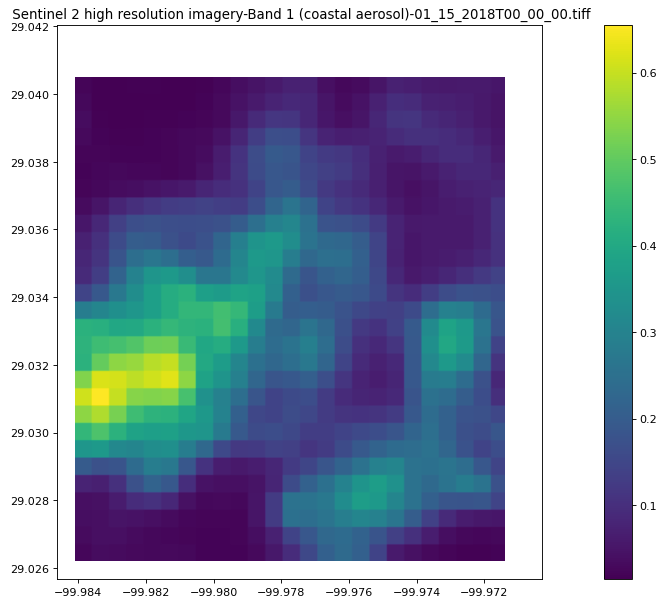

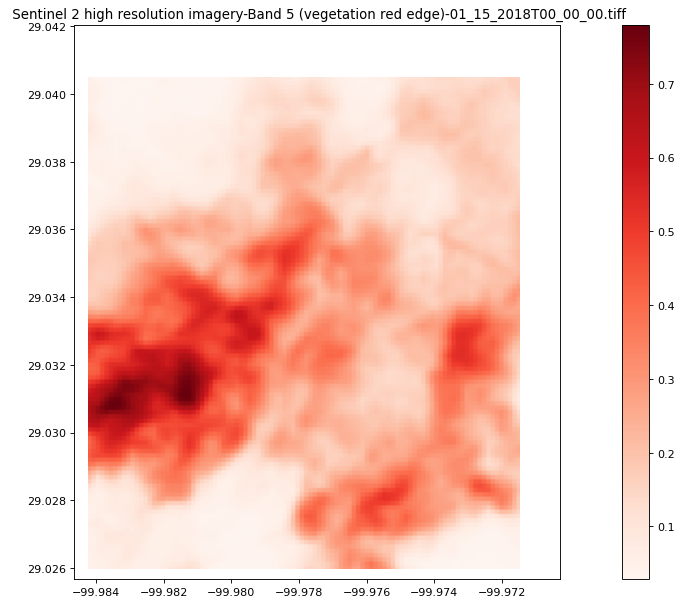

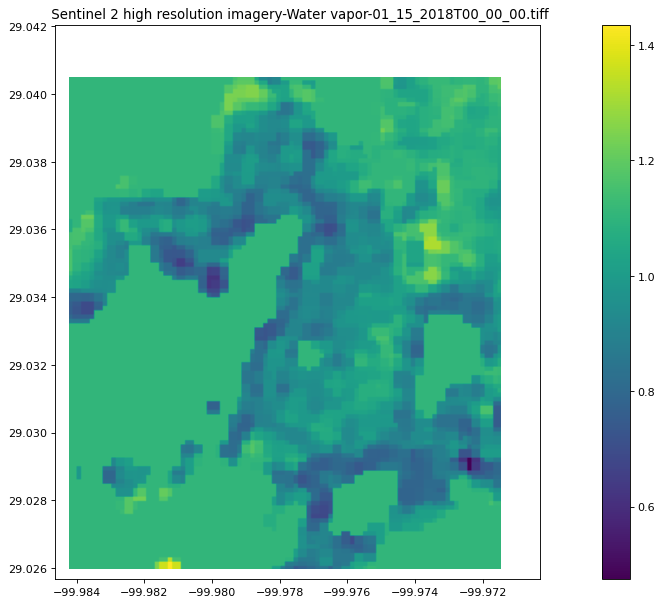

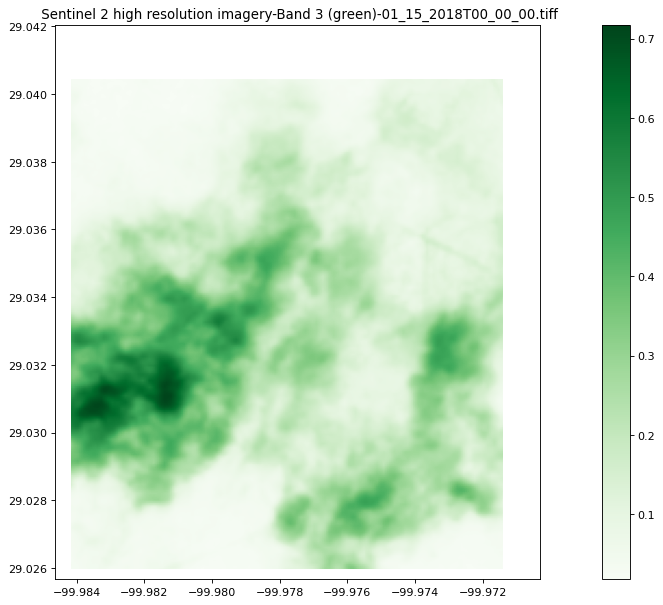

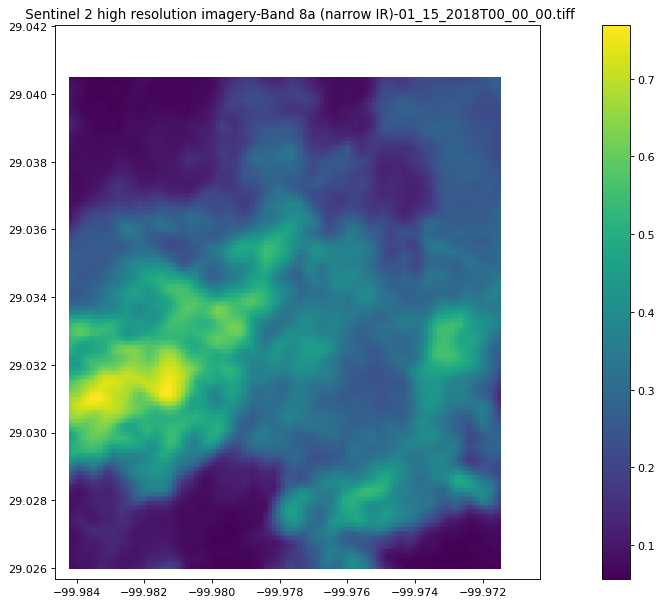

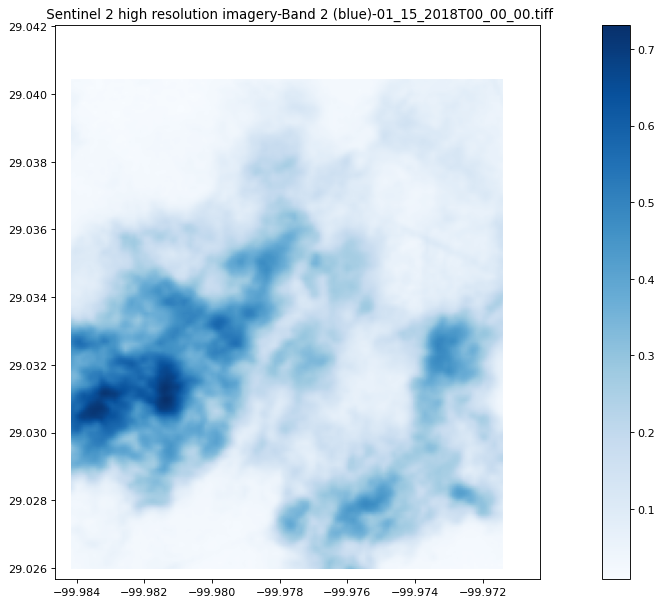

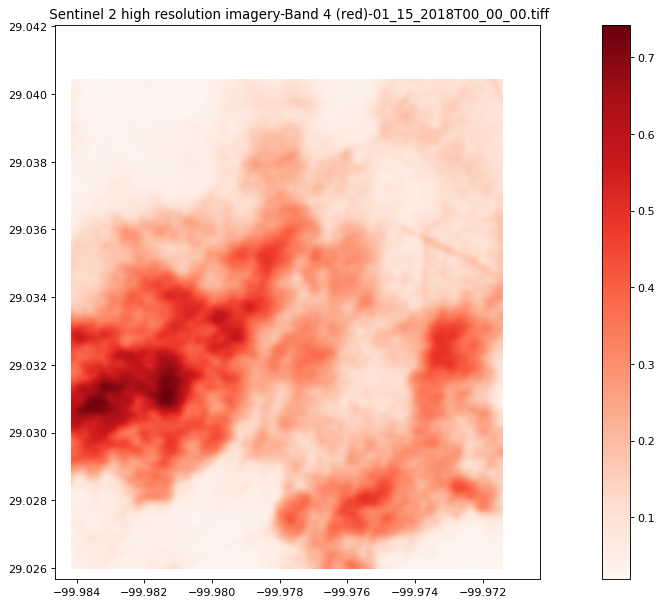

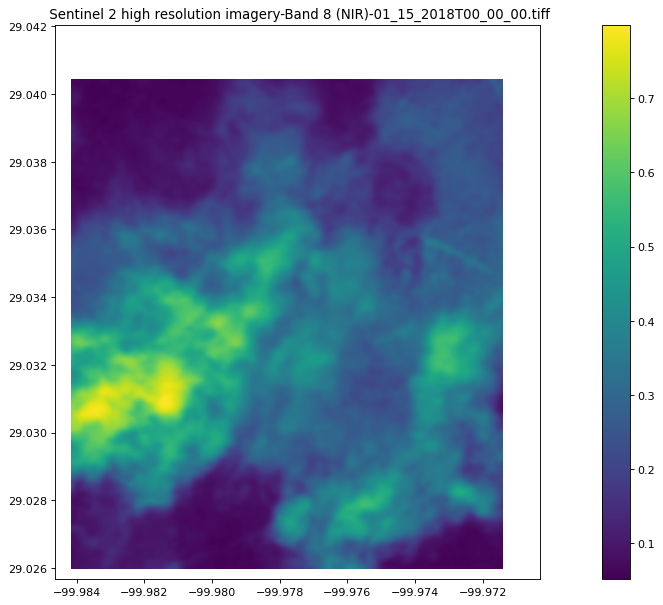

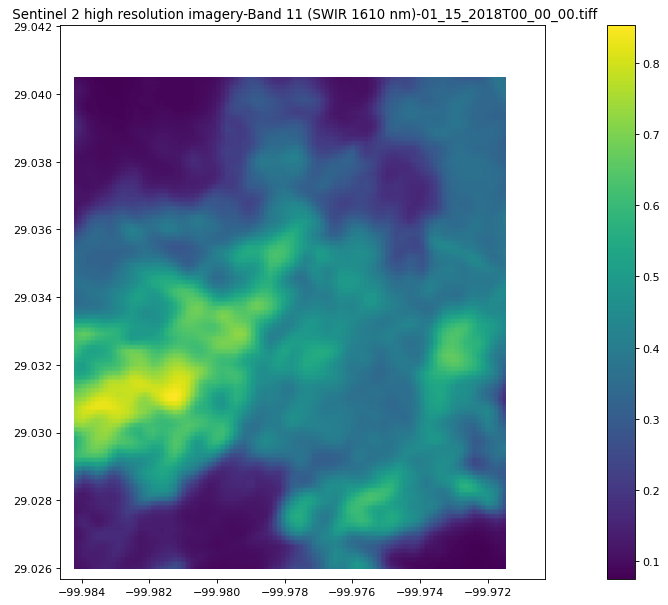

In [94]:
# Function to display the resulting Tiff(s).
Sentinel2_Result_file_list = Sentinel2Result.list_files()
output_image_array = []
for file in Sentinel2_Result_file_list:
    if file.endswith('.tiff'): #display the raster images
        with open(file+'.json', 'r') as summary_file:
            fileparms = json.load(summary_file)
        boundingBox=fileparms["boundingBox"]
        pixelStatistics=fileparms["rasterStatistics"]
        myextent=[boundingBox["minLongitude"],
                  boundingBox["maxLongitude"],
                  boundingBox["minLatitude"],
                  boundingBox["maxLatitude"]]  
        arrayS2 = np.array(PILImage.open(file))
        mask = (arrayS2 == -9999)
        # Masked array to exclude NO Data points from plotting
        masked_array = np.ma.masked_array(arrayS2, mask)
        plt.figure(figsize = (20, 9), dpi=80) # Sets the size and resolution of the plot
        if 'red' in file:
            plt.imshow(masked_array,
                       cmap = 'Reds',
                       vmin=pixelStatistics["pixelMin"], 
                       vmax=pixelStatistics["pixelMax"],
                       extent = myextent) # Loads the raster data and sets the colormap
        elif 'blue' in file:    
            plt.imshow(masked_array,
                       cmap = 'Blues', 
                       vmin=pixelStatistics["pixelMin"], 
                       vmax=pixelStatistics["pixelMax"],
                       extent = myextent) # Loads the raster data and sets the colormap
        elif 'green' in file:    
            plt.imshow(masked_array,
                       cmap = 'Greens', 
                       vmin=pixelStatistics["pixelMin"], 
                       vmax=pixelStatistics["pixelMax"],
                       extent = myextent) # Loads the raster data and sets the colormap
        else:
            plt.imshow(masked_array,
                       cmap = 'viridis', 
                       vmin=pixelStatistics["pixelMin"],
                       vmax=pixelStatistics["pixelMax"],
                       extent = myextent) # Loads the raster data and sets the colormap
        plt.colorbar() # Adds the color bar
        plt.title(" "+os.path.basename(file)) 
        output_image_path = os.path.splitext(os.path.basename(file))[0] + ".png"
        plt.savefig(output_image_path, bbox_inches='tight')
        output_image_array.append(output_image_path)
        plt.close()

for output_image in output_image_array:
    #display the raster images
    display(Image(output_image))

Each of the images above represents information on different bands that capture data across different parts of the electromagnetic spectrum for the specified location and temporal time period. Each band captures information that can be used for different applications, for example, the Green band is sensitive to vegetation health and provides information on chlorophyll content in plants, the Red and the Near-Infrared bands are widely used for analyzing vegetation through indices like NDVI (Normalized Difference Vegetation Index), the Coastal Aerosol band is used for aerosol correction and can help assess water quality and the Water Vapor band can be used for atmospheric correction and to monitor moisture levels in the air.

### References
- https://eo4geocourses.github.io/IGIK_Sentinel2-Data-and-Vegetation-Indices/#/
- https://docs.sentinel-hub.com/api/latest/data/sentinel-2-l2a/
- https://documentation.dataspace.copernicus.eu/APIs/SentinelHub/Data/S2L2A.html